In [201]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Activation,  LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
path = '/content/drive/MyDrive/dataset'

In [204]:
NUM_CLASSES = 2
ikan_classes = ["Segar", "Tidak Segar"]

names = []
nums = []
data = {'Name of class':[], 'Number of samples':[]}

for i in os.listdir(path+'/train'):
    if i == 'fresh':
        names.append('Segar')
    elif i == 'non-fresh':
        names.append('Tidak Segar')
    nums.append(len(os.listdir(path+'/train/'+i)))

data['Name of class'] += names
data['Number of samples'] += nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,Segar,35
1,Tidak Segar,35


<Axes: xlabel='Name of class', ylabel='Number of samples'>

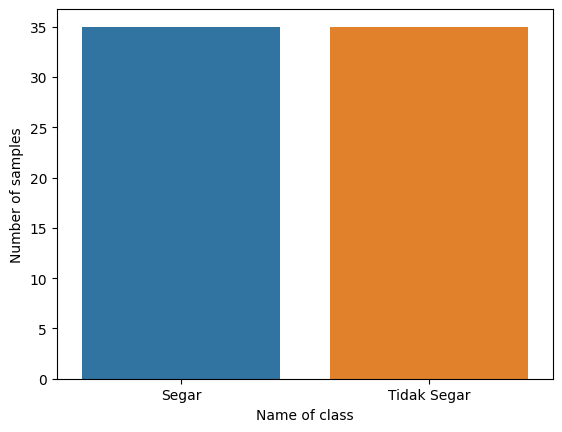

In [205]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

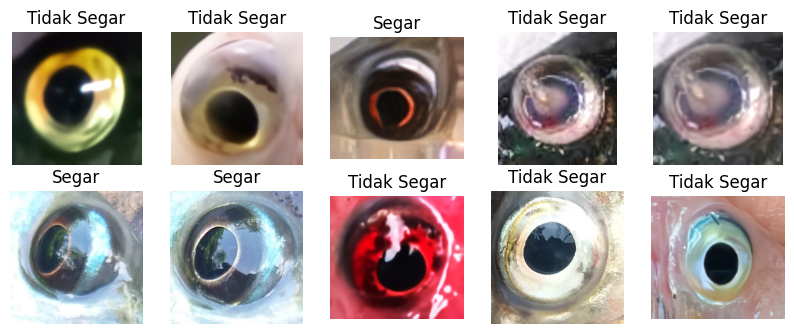

In [206]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(10, 10))
for x in range(10):
    i = random.randint(0, 1)  # getting the class (0 for Segar, 1 for Tidak Segar)
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0, len(images)-1)  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(ikan_classes[i])
    plt.axis("off")

plt.show()


# 3. Preparing the data

In [207]:
# Membuat objek ImageDataGenerator dengan konfigurasi augmentasi citra
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,               # Skala ulang intensitas piksel ke rentang 0-1
    horizontal_flip=True,         # Mengaktifkan flipping horizontal (memutar citra secara horizontal)
    vertical_flip=True,           # Mengaktifkan flipping vertikal (memutar citra secara vertikal)
    rotation_range=1,            # Rentang rotasi citra (dalam derajat)
    zoom_range=0.1,              # Rentang perbesaran citra
    width_shift_range=0.1,       # Rentang pergeseran horizontal citra
    height_shift_range=0.1,      # Rentang pergeseran vertikal citra
    shear_range=0.1,             # Rentang pergeseran sudut citra
    fill_mode="nearest",          # Metode pengisian piksel yang hilang saat augmentasi
    validation_split=0.2          # Pembagian data validasi sebesar 30% dari total data
)

In [208]:
# Mendefinisikan dataset pelatihan dan validasi menggunakan flow_from_directory
train_ds = image_datagen.flow_from_directory(
    path+'/train',
    target_size=(150, 150),
    batch_size=40,
    class_mode='categorical',
    subset='training'
)

val_ds = image_datagen.flow_from_directory(
    path+'/train',
    target_size=(150, 150),
    batch_size=40,
    class_mode='categorical',
    subset='validation'
)

Found 56 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


Found 56 images belonging to 2 classes.


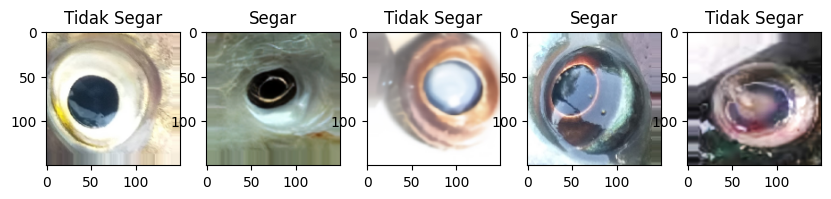

In [209]:
import matplotlib.pyplot as plt

# Mengambil citra-citra dari dataset menggunakan metode flow_from_directory
images, labels = next(image_datagen.flow_from_directory(
    path+'/train',
    target_size=(150, 150),
    batch_size=5,    # Jumlah citra yang akan diambil
    class_mode='categorical',
    subset='training'
))

# Mengonversi labels menjadi nama kelas
class_names = np.array(ikan_classes)
labels = np.argmax(labels, axis=1)
class_labels = class_names[labels]

# Menampilkan gambar-gambar dalam batch
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(class_labels[i])
plt.show()


# 4. Building the model

In [210]:
def make_model():
    ModelInception = tf.keras.models.Sequential([
        tf.keras.applications.InceptionV3(input_shape=(150, 150, 3),
                                          include_top=False,
                                          pooling='max',
                                          weights='imagenet'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return ModelInception


In [243]:
model = make_model()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0006, momentum=0.8),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_24 (Flatten)        (None, 2048)              0         
                                                                 
 dropout_24 (Dropout)        (None, 2048)              0         
                                                                 
 dense_48 (Dense)            (None, 32)                65568     
                                                                 
 dense_49 (Dense)            (None, 2)                 66        
                                                                 
Total params: 21,868,418
Trainable params: 21,833,986
Non-trainable params: 34,432
_________________________________________________________________


# 5. Training and evaluating

In [244]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 15)

Epoch 1/15
2/2 [==============================] - 19s 5s/step - loss: 0.8946 - accuracy: 0.5536 - val_loss: 1.3066 - val_accuracy: 0.5000
Epoch 2/15
2/2 [==============================] - 9s 6s/step - loss: 0.9482 - accuracy: 0.5357 - val_loss: 1.2231 - val_accuracy: 0.4286
Epoch 3/15
2/2 [==============================] - 9s 6s/step - loss: 0.8413 - accuracy: 0.6250 - val_loss: 1.4547 - val_accuracy: 0.4286
Epoch 4/15
2/2 [==============================] - 10s 4s/step - loss: 0.8859 - accuracy: 0.4643 - val_loss: 1.5209 - val_accuracy: 0.4286
Epoch 5/15
2/2 [==============================] - 8s 6s/step - loss: 0.8212 - accuracy: 0.6607 - val_loss: 1.1971 - val_accuracy: 0.5714
Epoch 6/15
2/2 [==============================] - 9s 6s/step - loss: 0.8010 - accuracy: 0.5536 - val_loss: 1.3882 - val_accuracy: 0.5000
Epoch 7/15
2/2 [==============================] - 9s 3s/step - loss: 0.7666 - accuracy: 0.6250 - val_loss: 1.4460 - val_accuracy: 0.5000
Epoch 8/15
2/2 [=======================

1/1 [==============================] - 1s 505ms/step - loss: 0.7668 - accuracy: 0.7143


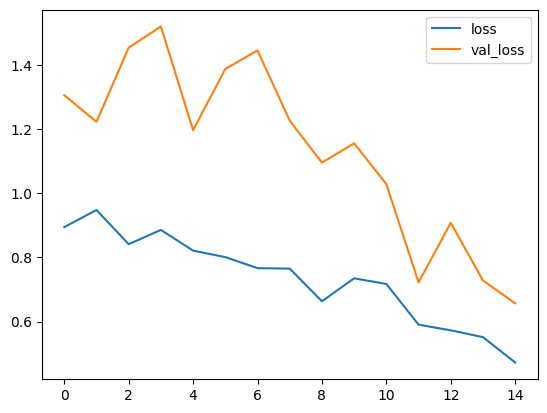

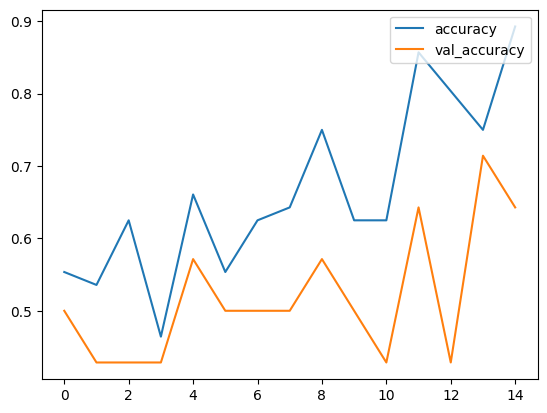

In [245]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [252]:
from sklearn.metrics import classification_report

# Get the predictions for the validation dataset
y_pred = model.predict(val_ds)

# Convert the predictions into class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels into class labels
y_true_classes = val_ds.classes

# Get the class names
class_names = list(val_ds.class_indices.keys())

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Print the classification report
print(report)

1/1 [==============================] - 1s 714ms/step
              precision    recall  f1-score   support

       fresh       0.60      0.86      0.71         7
   non-fresh       0.75      0.43      0.55         7

    accuracy                           0.64        14
   macro avg       0.68      0.64      0.63        14
weighted avg       0.67      0.64      0.63        14



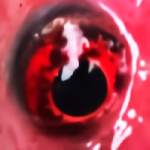

In [247]:
# Load the imageg
image_path = '/content/drive/MyDrive/dataset/train/non-fresh/non-fresh (4).jpg'
img = Image.open(image_path)
load_img(image_path,target_size=(150,150))

In [248]:
150# Resize the image to match the model's input shape
resized_img = img.resize((150, 150))

# Preprocess the image
input_image = np.array(resized_img) / 255.0
input_image = np.expand_dims(input_image, axis=0)

# Make the prediction
prediction = model.predict(input_image)
predicted_class = ikan_classes[np.argmax(prediction)]

print("Prediksi kelas:", predicted_class)


1/1 [==============================] - 1s 985ms/step
Prediksi kelas: Tidak Segar


# 6. Save Model


In [249]:
# Simpan model
# model.save('fish_classification_model_inception.h5')